In [28]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [29]:
df = pd.read_csv('train_df_2.csv')
df.shape

(1535, 13)

In [30]:
# Let's have a look at the data 
df.head()

,Unnamed: 0,RID,SID,text,polarity,category,target,aspect_term,aspect_category,cleaned_text,text_word,text_word_count,lemmatized
0,0,1000,1000:0,Manzara sahane evet ama servis rezalet.,negative,SERVICE#GENERAL,servis,SERVICE,GENERAL,manzara sahane evet servis rezalet,"['manzara', 'sahane', 'evet', 'servis', 'rezal...",5,manzara sahane evet servis rezalet
1,1,1000,1000:0,Manzara sahane evet ama servis rezalet.,positive,AMBIENCE#GENERAL,Manzara,AMBIENCE,GENERAL,manzara sahane evet servis rezalet,"['manzara', 'sahane', 'evet', 'servis', 'rezal...",5,manzara sahane evet servis rezalet
2,2,1000,1000:1,"Soguk su isteyince, soguk yok, butun sulari di...",negative,FOOD#STYLE_OPTIONS,mezenin,FOOD,STYLE_OPTIONS,soguk su isteyince soguk yok butun sulari disa...,"['soguk', 'su', 'isteyince', 'soguk', 'yok', '...",26,soguk su istemek soguk yok butun sulari disari...
3,3,1000,1000:1,"Soguk su isteyince, soguk yok, butun sulari di...",negative,SERVICE#GENERAL,garson,SERVICE,GENERAL,soguk su isteyince soguk yok butun sulari disa...,"['soguk', 'su', 'isteyince', 'soguk', 'yok', '...",26,soguk su istemek soguk yok butun sulari disari...
4,4,1000,1000:2,"Yemekler iyi hos, lezzetler iyi ama heyecan ve...",positive,FOOD#QUALITY,lezzetler,FOOD,QUALITY,yemekler iyi hos lezzetler iyi heyecan verici ...,"['yemekler', 'iyi', 'hos', 'lezzetler', 'iyi',...",21,yemek iyi hos lezzet iyi heyecan veri bi taraf...


In [31]:
# aspect encoding
from sklearn.preprocessing import LabelEncoder
df["category"] = df["category"].astype('category')
df["polarity"] = df["polarity"].astype('category')

df["category_cat"] = df["category"].cat.codes
df["polarity_cat"] = df["polarity"].cat.codes

df.head()

,Unnamed: 0,RID,SID,text,polarity,category,target,aspect_term,aspect_category,cleaned_text,text_word,text_word_count,lemmatized,category_cat,polarity_cat
0,0,1000,1000:0,Manzara sahane evet ama servis rezalet.,negative,SERVICE#GENERAL,servis,SERVICE,GENERAL,manzara sahane evet servis rezalet,"['manzara', 'sahane', 'evet', 'servis', 'rezal...",5,manzara sahane evet servis rezalet,11,0
1,1,1000,1000:0,Manzara sahane evet ama servis rezalet.,positive,AMBIENCE#GENERAL,Manzara,AMBIENCE,GENERAL,manzara sahane evet servis rezalet,"['manzara', 'sahane', 'evet', 'servis', 'rezal...",5,manzara sahane evet servis rezalet,0,2
2,2,1000,1000:1,"Soguk su isteyince, soguk yok, butun sulari di...",negative,FOOD#STYLE_OPTIONS,mezenin,FOOD,STYLE_OPTIONS,soguk su isteyince soguk yok butun sulari disa...,"['soguk', 'su', 'isteyince', 'soguk', 'yok', '...",26,soguk su istemek soguk yok butun sulari disari...,6,0
3,3,1000,1000:1,"Soguk su isteyince, soguk yok, butun sulari di...",negative,SERVICE#GENERAL,garson,SERVICE,GENERAL,soguk su isteyince soguk yok butun sulari disa...,"['soguk', 'su', 'isteyince', 'soguk', 'yok', '...",26,soguk su istemek soguk yok butun sulari disari...,11,0
4,4,1000,1000:2,"Yemekler iyi hos, lezzetler iyi ama heyecan ve...",positive,FOOD#QUALITY,lezzetler,FOOD,QUALITY,yemekler iyi hos lezzetler iyi heyecan verici ...,"['yemekler', 'iyi', 'hos', 'lezzetler', 'iyi',...",21,yemek iyi hos lezzet iyi heyecan veri bi taraf...,5,2


In [32]:
# Set the model name
MODEL_NAME = 'dbmdz/bert-base-turkish-128k-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [33]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 3
[CLS] 2
[PAD] 0
[UNK] 1


In [38]:
df_2 = pd.read_csv('reviews.csv')
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12495 non-null  object
 1   userName              12495 non-null  object
 2   userImage             12495 non-null  object
 3   content               12495 non-null  object
 4   score                 12495 non-null  int64 
 5   thumbsUpCount         12495 non-null  int64 
 6   reviewCreatedVersion  10333 non-null  object
 7   at                    12495 non-null  object
 8   replyContent          5818 non-null   object
 9   repliedAt             5818 non-null   object
 10  sortOrder             12495 non-null  object
 11  appId                 12495 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.1+ MB


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1535 entries, 0 to 1534
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Unnamed: 0       1535 non-null   int64   
 1   RID              1535 non-null   int64   
 2   SID              1535 non-null   object  
 3   text             1535 non-null   object  
 4   polarity         1535 non-null   category
 5   category         1535 non-null   category
 6   target           1385 non-null   object  
 7   aspect_term      1535 non-null   object  
 8   aspect_category  1535 non-null   object  
 9   cleaned_text     1533 non-null   object  
 10  text_word        1535 non-null   object  
 11  text_word_count  1535 non-null   int64   
 12  lemmatized       1533 non-null   object  
 13  category_cat     1535 non-null   int8    
 14  polarity_cat     1535 non-null   int8    
dtypes: category(2), int64(3), int8(2), object(8)
memory usage: 138.6+ KB


In [44]:
df.isnull().sum()

Unnamed: 0           0
RID                  0
SID                  0
text                 0
polarity             0
category             0
target             148
aspect_term          0
aspect_category      0
cleaned_text         0
text_word            0
text_word_count      0
lemmatized           0
category_cat         0
polarity_cat         0
dtype: int64

In [43]:
df.dropna(subset = ["lemmatized"], inplace=True)

In [39]:
df['lemmatized'] = df['lemmatized'].astype('object')

In [45]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.lemmatized:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

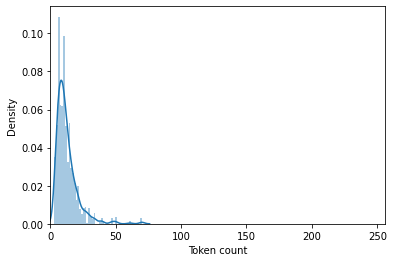

In [46]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [47]:
MAX_LEN = 100

In [48]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [50]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=24)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=24)

print(df_train.shape, df_val.shape, df_test.shape)

(1226, 15) (153, 15) (154, 15)


In [53]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.lemmatized.to_numpy(),
        targets=df.polarity_cat.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [54]:
# Create train, test and val data loaders
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [55]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32])


In [56]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [57]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

In [59]:
# Instantiate the model and move to classifier
model = SentimentClassifier(3)
model = model.to(device)

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [60]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


In [61]:
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [62]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [63]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [64]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 1.20 GiB already allocated; 0 bytes free; 1.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF